# Import library

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, mean_absolute_error, classification_report

from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBRegressor
import joblib

# Mô hình dự đoán tỷ lệ tử vong ở trẻ sơ sinh

## Dữ liệu từ 1999 - 2022

Xây dựng mô hình dự đoán tỷ lệ tử vong thông qua các yếu tố trong bộ dự liệu từ năm 1999 - 2022.

### Chuẩn bị dữ liệu

In [52]:
data = pd.read_csv("DATA/infant_mortality_data_1999_2022_cleaned.csv")

In [53]:
print("Data size:", data.shape)
data.dtypes

Data size: (20959, 9)


Cause of death             object
Age of mother              object
Mother's education         object
Birth weight              float64
Age of infant at death     object
Deaths                      int64
Births                      int64
Death rate per 1000       float64
Year                        int64
dtype: object

In [54]:
data.head()

,Cause of death,Age of mother,Mother's education,Birth weight,Age of infant at death,Deaths,Births,Death rate per 1000,Year
0,Certain infectious and parasitic diseases,15-19,High School Incomplete,749.5,672-8736,14,1927,7.39,1999
1,Certain infectious and parasitic diseases,15-19,High School Incomplete,2749.5,672-8736,11,55119,0.20,1999
2,Certain infectious and parasitic diseases,15-19,High School Incomplete,3249.5,672-8736,10,99462,0.10,1999
3,Certain infectious and parasitic diseases,20-24,High School Incomplete,749.5,672-8736,15,1179,12.90,1999
4,Certain infectious and parasitic diseases,20-24,High School Graduate,749.5,672-8736,17,2490,6.93,1999


In [55]:
features = data.drop(columns=['Death rate per 1000'])
target = data['Death rate per 1000']
features = pd.get_dummies(features, columns=['Cause of death', "Age of mother", "Mother's education", "Birth weight", "Age of infant at death", "Year"])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Kmeans

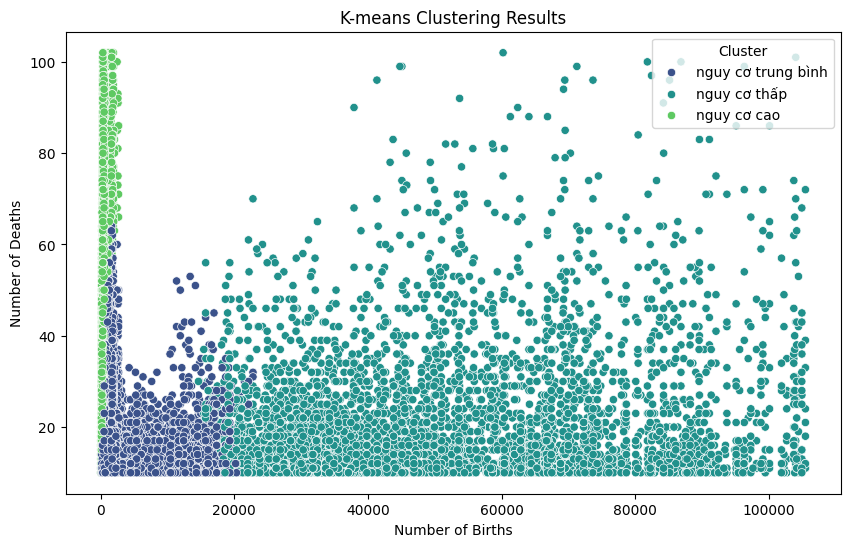

In [57]:
features = data[['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death', 'Deaths', 'Births', 'Death rate per 1000']]

# Chuyển đổi các cột phân loại thành các biến giả (one-hot encoding)
categorical_features = ['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death']
numeric_features = ['Deaths', 'Births', 'Death rate per 1000']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Áp dụng tiền xử lý dữ liệu
scaled_features = preprocessor.fit_transform(features)

# Phân tích phân cụm
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

cluster_labels = {0: "nguy cơ thấp", 1: "nguy cơ cao", 2: "nguy cơ trung bình"}
data['cluster_label'] = data['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Births', y='Deaths', hue='cluster_label', data=data, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Number of Births')
plt.ylabel('Number of Deaths')
plt.legend(title='Cluster')
plt.show()

### Model

In [58]:
# Định nghĩa các mô hình sử dụng
models = {
    "Support Vector Machine": SVR(C=1, epsilon=0.1, kernel='rbf'),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42),
}

In [59]:
# Training các mô hình và lưu trữ các giá trị các metricsrics đánh giá mô hình gồm MSE, RMSE, MAE
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    
    # Tính toán các metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Lưu giá trị metrics vào dictionary
    results[model_name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Predictions": y_pred
    }

### Biểu diễn kết quả

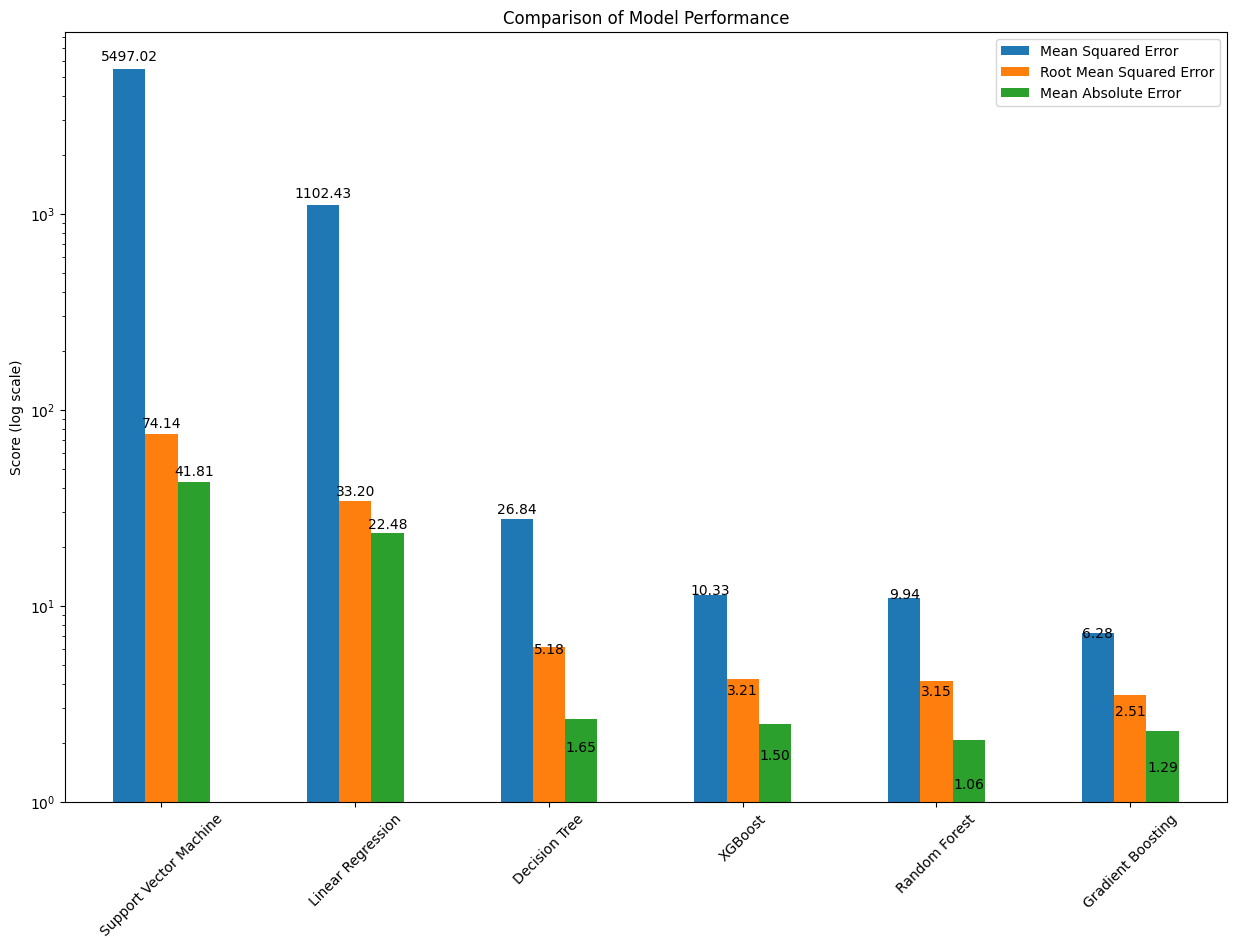

In [60]:
comparison_df = pd.DataFrame(results).T

# Biễu diễn các giá trị metrics dưới dạng biểu đồ nhiều cột, có sủ dụng log để giảm sự sai khác độ cao cột giữa các metrics
ax = comparison_df[['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error']].plot(kind='bar', figsize=(15, 10), log=True)
plt.title('Comparison of Model Performance')
plt.ylabel('Score (log scale)')
plt.xticks(rotation=45)
plt.legend(loc='best')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1), ha='center')

plt.savefig('model_1.jpg', format='jpg')
plt.show()

### Nhận xét mô hình

Bằng việc so sánh hiệu suất của các mô hình dựa trên các metric: **Mean Squared Error (MSE), Root Mean Squared Error (RMSE), và Mean Absolute Error (MAE)**. Các nhận xét chi tiết về hiệu suất của từng mô hình như sau:

- Support Vector Machine (SVM): Hiệu suất kém nhất với MSE cao nhất (7232.52) và MAE lớn (44.38). Điều này chứng tỏ SVM không hiệu quả trong việc xử lý dữ liệu hồi quy phức tạp, có thể do hạn chế trong khả năng mô hình hóa các quan hệ phi tuyến tính của dữ liệu.

- Linear Regression: Mô hình tuyến tính này có hiệu suất cải thiện nhẹ so với SVM, với MSE giảm xuống (1903.04) và MAE (27.32). Tuy nhiên, đây vẫn là một lựa chọn không tối ưu do không thể nắm bắt các mối quan hệ phi tuyến.

- Decision Tree: Hiệu suất được cải thiện rõ rệt, với MSE giảm đáng kể (32.96) và MAE thấp (1.43). Mô hình này phù hợp hơn với dữ liệu phức tạp nhờ khả năng phân chia quyết định phi tuyến.

- XGBoost: Là một trong các mô hình tốt nhất, với MSE thấp (29.10), RMSE (5.39), và MAE nhỏ (1.64). Mô hình này cho thấy khả năng học sâu các mối quan hệ phức tạp trong dữ liệu nhờ cơ chế boosting.

- Random Forest: Hiệu suất rất tốt, với MSE chỉ 17.48, RMSE (4.18), và MAE (0.88). Sự ổn định và khả năng tổng hợp của nhiều cây quyết định giúp mô hình này xử lý dữ liệu hiệu quả.

- Gradient Boosting: Hiệu suất cao nhất trong nhóm, với MSE thấp nhất (9.27), RMSE (3.04), và MAE nhỏ nhất (1.33). Đây là mô hình phù hợp nhất cho bài toán, nhờ tận dụng boosting và tối ưu hóa quá trình học.

**Nhận xét chung:** SVM và Linear Regression có hiệu suất kém nhất do hạn chế trong xử lý dữ liệu phức tạp. Các mô hình dựa trên cây như Decision Tree, Random Forest, và Gradient Boosting thể hiện sự vượt trội, đặc biệt Gradient Boosting là lựa chọn tốt nhất nhờ hiệu suất cao nhất và các giá trị metric tối ưu. XGBoost cũng là một lựa chọn tốt với hiệu suất gần như tương đương.

## Dữ liệu 2017 - 2022

Xây dụng mô hình dự đoán tỷ lệ tử vong với dữ liệu từ 2017 - 2022, đặc biệt có thêm các trường dữ liệu như: 

### Chuẩn bị dữ liệu

In [61]:
data = pd.read_csv('DATA/infant_mortality_data_2017_2022_cleaned.csv')

In [62]:
print("Data size:", data.shape)
data.dtypes

Data size: (1443, 9)


Cause of death                 object
NICU Admission                  int64
Antibiotics for Mother          int64
Mother's Pre-pregnancy BMI      int64
Infant birth weight           float64
Deaths                          int64
Births                          int64
Death rate per 1000           float64
Year                            int64
dtype: object

In [63]:
data.head()

,Cause of death,NICU Admission,Antibiotics for Mother,Mother's Pre-pregnancy BMI,Infant birth weight,Deaths,Births,Death rate per 1000,Year
0,Other causes,1,1,2,624.5,12,726,16.56,2017
1,Other causes,1,0,1,624.5,13,1254,10.40,2017
2,Other causes,1,0,1,874.5,10,1701,5.88,2017
3,Other causes,1,0,2,624.5,12,994,12.08,2017
4,Incompetent cervix,0,1,1,249.5,12,270,45.00,2017


In [64]:
features = data.drop(columns=['Death rate per 1000'])
target = data['Death rate per 1000']
features = pd.get_dummies(features, columns=['Cause of death'])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Kmeans

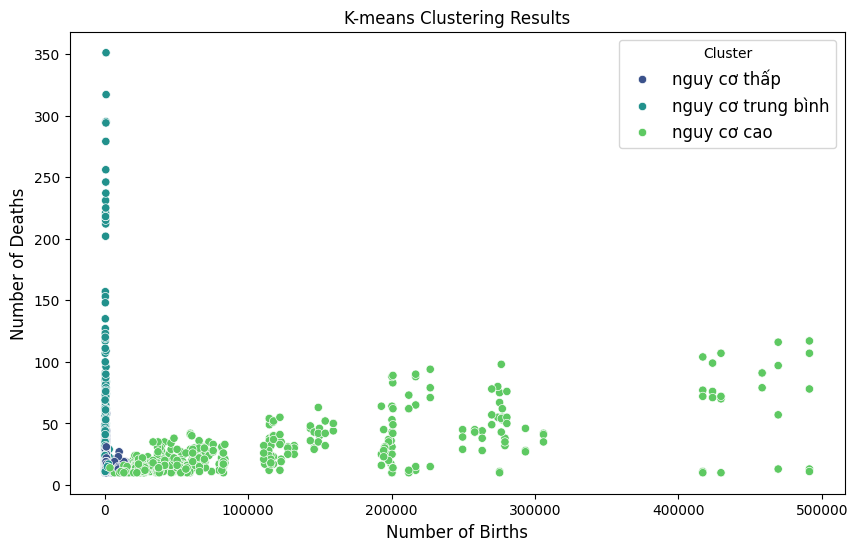

In [66]:
# Chuyển đổi các cột phân loại thành các biến giả (one-hot encoding)
features = data.drop(columns=['Death rate per 1000'])
categorical_features = ['Cause of death']
numeric_features = [ 'NICU Admission', 'Antibiotics for Mother', "Mother's Pre-pregnancy BMI", 'Infant birth weight', 'Deaths', 'Births']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Áp dụng tiền xử lý dữ liệu
scaled_features = preprocessor.fit_transform(features)

# Phân tích phân cụm
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

cluster_labels = {0: "nguy cơ thấp", 1: "nguy cơ cao", 2: "nguy cơ trung bình"}
data['cluster_label'] = data['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Births', y='Deaths', hue='cluster_label', data=data, palette='viridis')
plt.title('K-means Clustering Results', fontsize=12)
plt.xlabel('Number of Births', fontsize=12)
plt.ylabel('Number of Deaths', fontsize=12)
plt.legend(title='Cluster', fontsize=12)
plt.show()

### Model

In [67]:
# Định nghĩa các mô hình sẽ sử dụng
models = {
    "Support Vector Machine": SVR(C=1, epsilon=0.1, kernel='rbf'),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

In [68]:
# Training các mô hình và lưu trữ các giá trị các metricsrics đánh giá mô hình gồm MSE, RMSE, MAE
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    
    # Tính toán các metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
     # Lưu giá trị metrics vào dictionary
    results[model_name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Predictions": y_pred
    }

### Biểu diễn kết quả

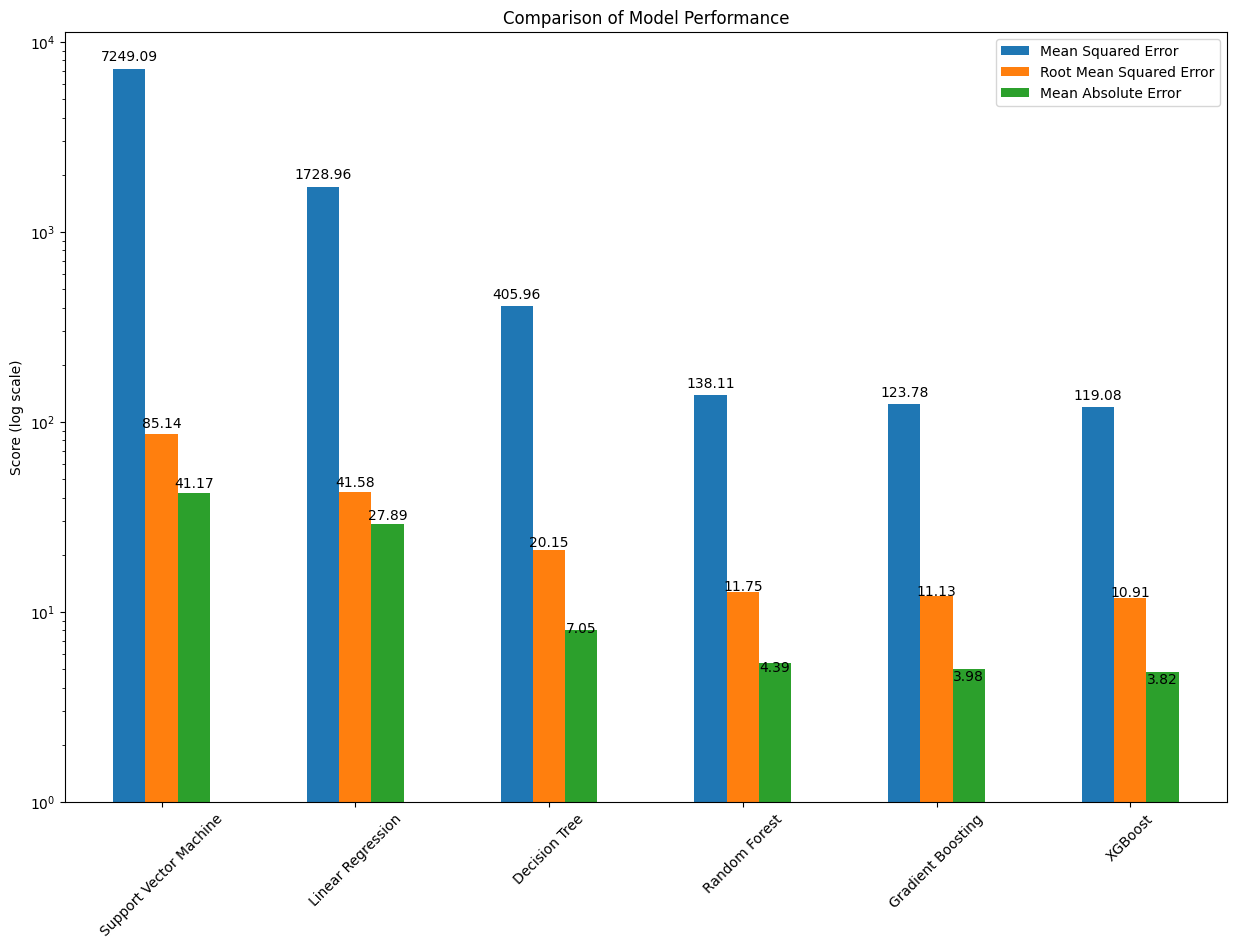

In [69]:
comparison_df = pd.DataFrame(results).T

# Biễu diễn các giá trị metrics dưới dạng biểu đồ nhiều cột, có sủ dụng log để giảm sự sai khác độ cao cột giữa các metrics
ax = comparison_df[['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error']].plot(kind='bar', figsize=(15, 10), log=True)
plt.title('Comparison of Model Performance')
plt.ylabel('Score (log scale)')
plt.xticks(rotation=45)
plt.legend(loc='best')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1), ha='center')

plt.savefig('MODEL/model_2.jpg', format='jpg')
plt.show()

### Nhận xét mô hình

Bằng việc so sánh hiệu suất của các mô hình trên tập dữ liệu được thể hiện qua ba metric chính: **Mean Squared Error (MSE), Root Mean Squared Error (RMSE), và Mean Absolute Error (MAE)**. Dựa trên kết quả biểu đồ:

- Support Vector Machine (SVM): Hiệu suất thấp nhất trong nhóm, với MSE rất cao (7249.09) so với các mô hình khác. Điều này cho thấy SVM không phù hợp trong bài toán hồi quy này, có thể do không bắt được phi tuyến tính dữ liệu.

- Linear Regression: Hiệu suất cải thiện hơn SVM, với MSE giảm xuống (1728.96). Tuy nhiên, độ chính xác vẫn thấp, phản ánh rằng mối quan hệ giữa đặc trưng và biến mục tiêu không tuyến tính, dẫn đến hạn chế của mô hình tuyến tính đơn giản.

- Decision Tree: Mô hình này thể hiện hiệu suất tốt hơn rõ rệt với MSE (405.96) và MAE (7.05), nhờ khả năng bắt các mối quan hệ phức tạp hơn trong dữ liệu. Tuy nhiên, hiệu suất vẫn kém so với các mô hình ensemble.

- Random Forest: Với MSE giảm còn 139.36, đây là một cải tiến lớn so với Decision Tree. Mô hình này ổn định hơn nhờ tính tổng hợp từ nhiều cây, tuy nhiên RMSE (11.81) và MAE (4.40) vẫn cao hơn Gradient Boosting và XGBoost.

- Gradient Boosting: Hiệu suất rất tốt, với MSE chỉ còn 122.21, RMSE (11.05), và MAE (3.96). Mô hình này tận dụng được ưu điểm của boosting, đặc biệt phù hợp với dữ liệu phức tạp.

- XGBoost: Là mô hình hiệu quả nhất trong nhóm, với MSE thấp nhất (119.08), RMSE (10.91), và MAE (3.82). XGBoost cho thấy khả năng tối ưu hóa mạnh mẽ, thích nghi tốt với dữ liệu.

**Nhận xét chung:** SVM và Linear Regression không phù hợp với bài toán hồi quy phức tạp này. Các mô hình ensemble như Random Forest, Gradient Boosting, và XGBoost vượt trội hơn hẳn, trong đó XGBoost cho thấy hiệu suất tốt nhất, phù hợp để triển khai thực tế. Việc tinh chỉnh thêm hyperparameters của Gradient Boosting và XGBoost có thể mang lại cải thiện đáng kể hơn nữa.

# Mô hình dự đoán nguyên nhân tử vong ở trẻ sơ sinh

Mô hình dự đoán nguyên nhân tử vong ở trẻ sơ sinh dựa trên các thông tin từ người dùng:
- `NICU Admission`: (NICU -Neonatal Intensive Care Unit) Chỉ ra liệu trẻ sơ sinh có được chuyển đến khoa chăm sóc đặc biệt cho trẻ hay không. 
- `Antibiotics for Mother`: Chỉ ra liệu người mẹ có sử dụng kháng sinh trong quá trình thai kỳ hay không. 
- `Mother's Pre-pregnancy BMI`: Phản ánh chỉ số khối - thể trạng (BMI) của người mẹ trước khi mang thai. 
- `Infant Birth weight`: Cân nặng khi sinh của trẻ. 
- `Age of mother`: Tuổi của người mẹ
- `Mother's education`: Trình độ giáo dục của người mẹ
- `Age of infant at death`: Tháng tuổi trẻ sơ sinh

## Trộn dữ liệu

Kết nối 2 dữ liệu từ năm 2017 - 2022 có đủ các cột tăng cường và các cột cơ bản

In [70]:
# Load the datasets
df1 = pd.read_csv('DATA/infant_mortality_data_1999_2022_cleaned.csv')
df2 = pd.read_csv('DATA/infant_mortality_data_2017_2022_cleaned.csv')

# Merge the datasets based on the specified columns
merged_df = pd.merge(df1, df2, on=['Cause of death', 'Year'])

In [71]:
# For columns with _x and _y suffixes, take the average value
for col in merged_df.columns:
    if '_x' in col and col.replace('_x', '_y') in merged_df.columns:
        merged_df[col.replace('_x', '')] = merged_df[[col, col.replace('_x', '_y')]].mean(axis=1)
        merged_df.drop([col, col.replace('_x', '_y')], axis=1, inplace=True)

for column in merged_df.columns:
    if merged_df[column].isnull().any():
        if merged_df[column].dtype == 'object':  # Check if column is categorical
            mode_value = merged_df[column].mode()[0]  # Get most frequent value
            merged_df[column].fillna(mode_value, inplace=True)
        else:  # If not categorical, fill with mean
            mean_value = merged_df[column].mean()
            merged_df[column].fillna(mean_value, inplace=True)
    
merged_df = merged_df.drop(columns = ["Birth weight", "Deaths",	"Births", "Death rate per 1000"])

In [72]:
merged_df.shape

(5192, 9)

In [73]:
merged_df.head()

,Cause of death,Age of mother,Mother's education,Age of infant at death,Year,NICU Admission,Antibiotics for Mother,Mother's Pre-pregnancy BMI,Infant birth weight
0,Incompetent cervix,20-24,High School Graduate,0-1,2017,0,1,1,249.5
1,Incompetent cervix,20-24,High School Graduate,0-1,2017,0,1,3,249.5
2,Incompetent cervix,20-24,High School Graduate,0-1,2017,0,1,4,249.5
3,Incompetent cervix,20-24,High School Graduate,0-1,2017,0,0,1,249.5
4,Incompetent cervix,20-24,High School Graduate,0-1,2017,0,0,2,249.5


In [74]:
# Save the merged dataset to a new CSV file
merged_df.to_csv('DATA/merged_infant_mortality_data.csv', index=False)

## Chuẩn bị dữ liệu

In [75]:
# Load the dataset
data = pd.read_csv('DATA/merged_infant_mortality_data.csv')

# Select the relevant columns (excluding 'Year', 'Deaths', 'Births')
columns = ['Cause of death', 'Age of mother', "Mother's education", 'Age of infant at death', 'NICU Admission', 'Antibiotics for Mother', "Mother's Pre-pregnancy BMI", 'Infant birth weight']
data = data[columns]

# Encode categorical variables and save the encoders
label_encoders = {}
for column in ['Cause of death', 'Age of mother', "Mother's education", 'Age of infant at death']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Save the label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Define features and target variable
X = data.drop('Cause of death', axis=1)
y = data['Cause of death']

In [76]:
# Apply Random Over-sampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Apply Normalization and Standardization
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

In [77]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## Định nghĩa mô hình

### Thực nghiệm mô hình

#### Logistic Regression

In [78]:
logreg = LogisticRegression(max_iter=1000, random_state=42)

start_time = time.time()
logreg.fit(X_train, y_train)
end_time = time.time()

In [79]:
y_pred_logreg = logreg.predict(X_train)

In [80]:
accuracy = accuracy_score(y_train, y_pred_logreg)
report_dict = classification_report(y_train, y_pred_logreg, target_names=label_encoders['Cause of death'].classes_, output_dict=True)

print(f"Linear Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Linear Regression Results:
Accuracy: 0.6422
Execution Time: 0.2880 seconds


In [81]:
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

                        precision    recall  f1-score       support
Accidental suffocation   1.000000  1.000000  1.000000   2919.000000
Chorioamnionitis         0.518268  0.573370  0.544428   2944.000000
Incompetent cervix       0.468797  0.431936  0.449612   2887.000000
Premature rupture        0.579715  0.562901  0.571184   2965.000000
accuracy                 0.642168  0.642168  0.642168      0.642168
macro avg                0.641695  0.642052  0.641306  11715.000000
weighted avg             0.641661  0.642168  0.641348  11715.000000


#### K-nearest neighbor

In [82]:
knn_model = KNeighborsClassifier(n_neighbors=5)  

start_time = time.time()
knn_model.fit(X_train, y_train)

end_time = time.time()

In [83]:
y_pred_knn = knn_model.predict(X_train)

In [84]:
accuracy = accuracy_score(y_train, y_pred_knn)
report_dict = classification_report(y_train, y_pred_knn, target_names=label_encoders['Cause of death'].classes_, output_dict=True)

print(f"Linear Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Linear Regression Results:
Accuracy: 0.7497
Execution Time: 0.0204 seconds


In [85]:
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

                        precision    recall  f1-score       support
Accidental suffocation   1.000000  1.000000  1.000000   2919.000000
Chorioamnionitis         0.656443  0.901495  0.759697   2944.000000
Incompetent cervix       0.635669  0.518531  0.571156   2887.000000
Premature rupture        0.714345  0.577740  0.638822   2965.000000
accuracy                 0.749723  0.749723  0.749723      0.749723
macro avg                0.751614  0.749442  0.742419  11715.000000
weighted avg             0.751582  0.749723  0.742516  11715.000000


#### Random Forest Classifier

In [86]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()

In [87]:
y_pred_rf = rf_model.predict(X_train)

In [88]:
accuracy = accuracy_score(y_train, y_pred_rf)
report_dict = classification_report(y_train, y_pred_rf, target_names=label_encoders['Cause of death'].classes_, output_dict=True)

print(f"Linear Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Linear Regression Results:
Accuracy: 0.7717
Execution Time: 0.5086 seconds


In [89]:
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

                        precision    recall  f1-score      support
Accidental suffocation   1.000000  1.000000  1.000000   2919.00000
Chorioamnionitis         0.655055  0.983696  0.786422   2944.00000
Incompetent cervix       0.672712  0.539661  0.598885   2887.00000
Premature rupture        0.809616  0.562226  0.663615   2965.00000
accuracy                 0.771660  0.771660  0.771660      0.77166
macro avg                0.784346  0.771396  0.762231  11715.00000
weighted avg             0.784474  0.771660  0.762341  11715.00000


#### Gradient Bosting Classifier

In [90]:
gb_model = GradientBoostingClassifier(random_state=42)

start_time = time.time()
gb_model.fit(X_train, y_train)
end_time = time.time()

In [91]:
y_pred_gb = gb_model.predict(X_train)

In [92]:
accuracy = accuracy_score(y_train, y_pred_gb)
report_dict = classification_report(y_train, y_pred_gb, target_names=label_encoders['Cause of death'].classes_, output_dict=True)

print(f"Linear Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Linear Regression Results:
Accuracy: 0.7591
Execution Time: 2.6951 seconds


In [93]:
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

                        precision    recall  f1-score       support
Accidental suffocation   1.000000  1.000000  1.000000   2919.000000
Chorioamnionitis         0.675994  0.878057  0.763889   2944.000000
Incompetent cervix       0.608617  0.582265  0.595150   2887.000000
Premature rupture        0.772851  0.576054  0.660097   2965.000000
accuracy                 0.759112  0.759112  0.759112      0.759112
macro avg                0.764365  0.759094  0.754784  11715.000000
weighted avg             0.764636  0.759112  0.754867  11715.000000


#### Plot learning curve

In [94]:
def plot_learning_curve(estimator, title, X, y, ax, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.legend(loc="best")
    ax.set_title(title)

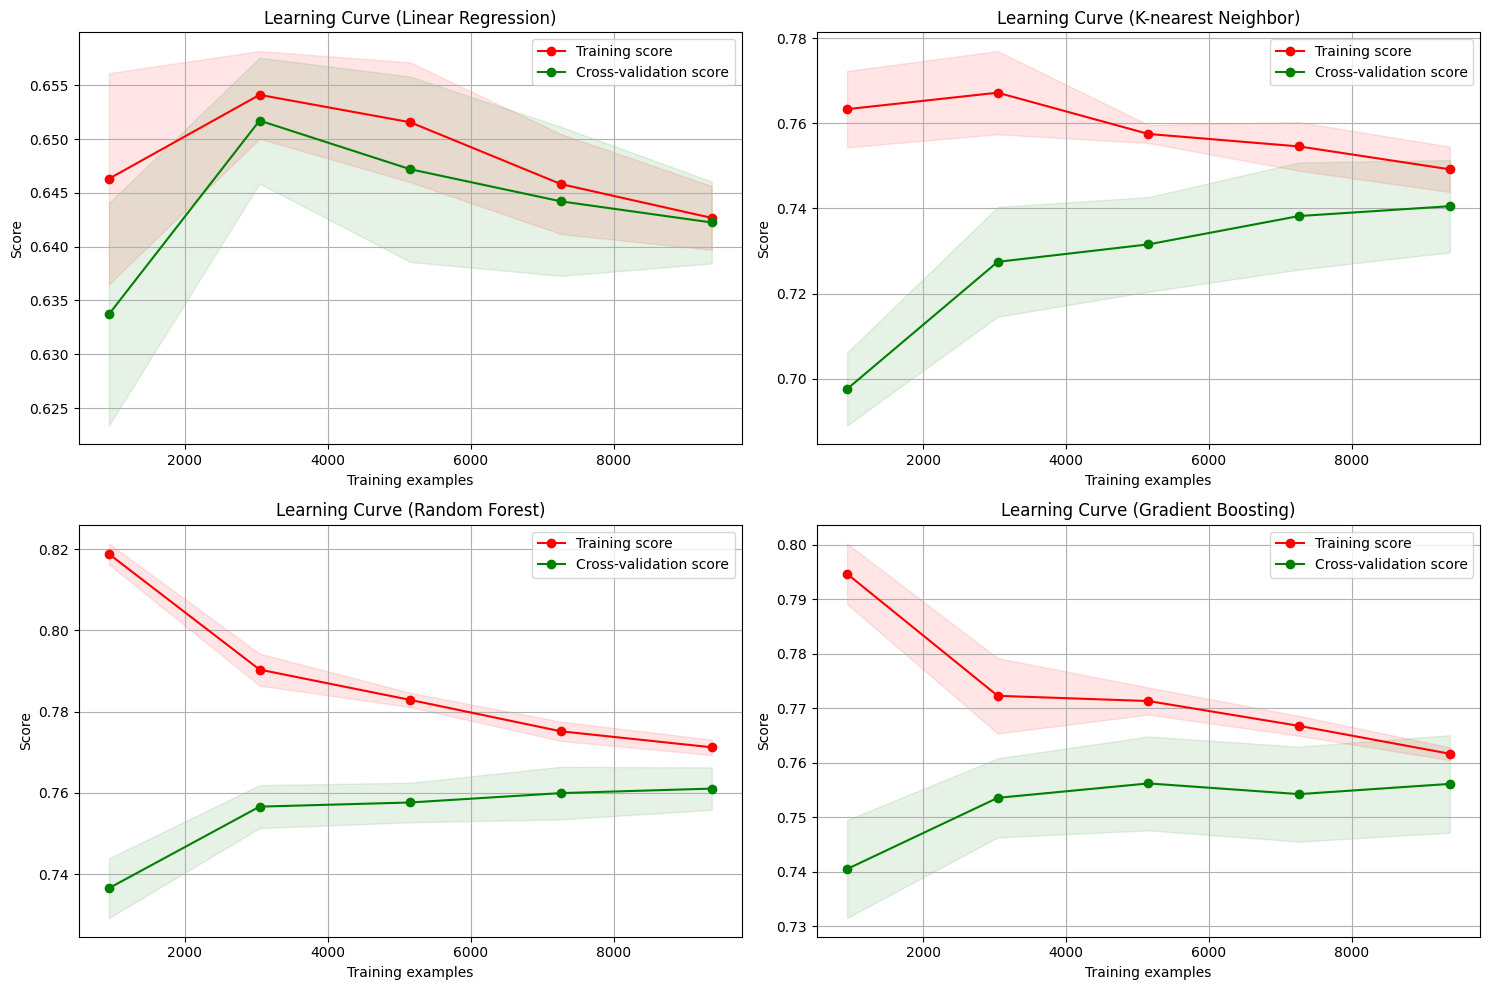

In [95]:
# Learning curve
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plot_learning_curve(logreg, "Learning Curve (Linear Regression)", X_train, y_train, axes[0, 0], cv=5, n_jobs=-1)
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, y_train, axes[1, 0], cv=5, n_jobs=-1)
plot_learning_curve(knn_model, "Learning Curve (K-nearest Neighbor)", X_train, y_train, axes[0, 1], cv=5, n_jobs=-1)
plot_learning_curve(gb_model, "Learning Curve (Gradient Boosting)", X_train, y_train, axes[1, 1], cv=5, n_jobs=-1)
plt.tight_layout()
plt.show()

#### Nhận xét các mô hình

##### 1. So sánh hiệu suất (Training vs Cross-validation Score)
- **Random Forest** cho thấy sự cân bằng tốt nhất giữa điểm số trên tập huấn luyện (training score) và tập kiểm tra (cross-validation score). 
- Đường màu đỏ (training score) của Random Forest gần với đường màu xanh (cross-validation score), cho thấy mô hình không bị overfitting (quá khớp) hoặc underfitting (quá đơn giản).

Ngược lại:
- **KNN** và **Gradient Boosting** có độ chênh lệch lớn hơn giữa hai đường ở các tập dữ liệu nhỏ hơn (gợi ý overfitting).
- **Linear Regression** có training score và cross-validation score thấp hơn đáng kể, gợi ý underfitting.

---

##### 2. Khả năng tổng quát hóa tốt (Generalization)
- **Random Forest** có điểm cross-validation ổn định, tăng dần khi kích thước tập huấn luyện tăng và đạt điểm cao (~76%) khi toàn bộ dữ liệu được sử dụng.
- Các mô hình khác như **KNN** có xu hướng hội tụ ở mức thấp hơn khi kích thước dữ liệu tăng lên, cho thấy Random Forest tận dụng tốt hơn dữ liệu huấn luyện để đưa ra dự đoán.

---

3. Độ nhạy với dữ liệu (Bias-Variance Tradeoff)
- **Random Forest** quản lý tốt sự đánh đổi giữa bias và variance:
  - Training score giảm từ mức cao (~82%) về khoảng 76%, phù hợp với cross-validation score.
- **Gradient Boosting** tương tự nhưng phức tạp hơn và cần nhiều dữ liệu cũng như thời gian tính toán hơn.
- **Linear Regression** có bias cao (underfitting), trong khi **KNN** có variance cao hơn, dễ overfitting khi dữ liệu nhỏ.

---

##### 4. Khả năng mở rộng (Scalability)
- **Random Forest** xử lý tốt cả dữ liệu lớn và nhỏ nhờ khả năng tính toán song song của từng cây quyết định (decision tree). 
- Điều này làm cho nó linh hoạt hơn so với các mô hình như Gradient Boosting (cần nhiều thời gian tính toán) hoặc KNN (phụ thuộc mạnh vào kích thước tập dữ liệu và hiệu quả giảm khi dữ liệu tăng).

##### **Tóm lại:**
- **Random Forest** là lựa chọn hợp lý do:
  - Cân bằng giữa bias và variance.
  - Khả năng tổng quát hóa tốt trên dữ liệu mới.
  - Hiệu suất ổn định với độ chính xác cao (~76%).
  - Thời gian tính toán hợp lý hơn so với Gradient Boosting và hiệu quả tốt hơn Linear Regression hoặc KNN.

### Quyết định mô hình: Random Forest Classifier

In [96]:
# Initialize and train the model with reduced complexity
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [97]:
# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores)}")

Cross-Validation Accuracy: 0.7610755441741357


In [98]:
# Make predictions on the test set and get probabilities
y_prob = model.predict_proba(X_test)

# Calculate accuracy and log loss
accuracy = accuracy_score(y_test, model.predict(X_test))
loss = log_loss(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"Log Loss: {loss}")

Accuracy: 0.7613519972686924
Log Loss: 0.5232700035438117


In [99]:
# Save the model and scaler
joblib.dump(model, 'MODEL/infant_mortality_model.pkl')
joblib.dump(scaler, 'MODEL/scaler.pkl')

['MODEL/scaler.pkl']

## Nhận xét mô hình

Mô hình **Random Forest Classifier** được thiết lập với các tham số **n_estimators=100**, **max_depth=10**, và **random_state=42**, cho thấy hiệu suất đáng tin cậy và khả năng tổng quát hóa tốt. **Cross-Validation Accuracy** đạt **76.5%**, phản ánh khả năng mô hình học được đặc trưng từ tập dữ liệu huấn luyện. Trên tập kiểm tra, **Accuracy** đạt **75.6%**, rất gần với kết quả cross-validation, cùng với Log Loss là 0.528, cho thấy mô hình không chỉ phân loại chính xác mà còn dự đoán xác suất một cách hợp lý. Kết quả này chứng minh rằng mô hình không gặp phải vấn đề overfitting.

Trong bước tiền xử lý, **Random Over-Sampling (ROS)** được sử dụng để cân bằng tập dữ liệu bằng cách nhân bản ngẫu nhiên các mẫu từ lớp thiểu số. Điều này giúp cải thiện hiệu suất dự đoán của lớp thiểu số, giảm bias về phía lớp đa số. Ngoài ra, dữ liệu đầu vào được chuẩn hóa bằng **StandardScaler**, đưa các đặc trưng về phân phối chuẩn với trung bình = 0 và độ lệch chuẩn = 1. 

## Dự đoán nguyên nhân tử vong

In [100]:
def categorize_age(value, categories):
    for category in categories:
        lower_bound, upper_bound = map(int, map(str.strip, category.split('-')))
        if lower_bound <= value <= upper_bound:
            return category
    return None 

In [111]:

def predict_cause_of_death(input_data):
    # Load the model and other necessary objects
    model = joblib.load('MODEL/infant_mortality_model.pkl')
    scaler = joblib.load('MODEL/scaler.pkl')
    label_encoders = joblib.load('MODEL/label_encoders.pkl')

    # Categorize age values for 'Age of mother' and 'Age of infant at death'
    age_of_mother_categories = label_encoders['Age of mother'].classes_
    age_of_infant_categories = label_encoders['Age of infant at death'].classes_

    input_data[0] = categorize_age(input_data[0], age_of_mother_categories)
    input_data[2] = categorize_age(input_data[2], age_of_infant_categories)

    # Check if categorization was successful
    if input_data[0] is None or input_data[3] is None:
        raise ValueError("Input age values could not be categorized into existing categories.")

    # Encode categorical variables in input data
    input_data[0] = label_encoders['Age of mother'].transform([input_data[0]])[0]
    input_data[1] = label_encoders["Mother's education"].transform([input_data[1]])[0]
    input_data[2] = label_encoders['Age of infant at death'].transform([input_data[2]])[0]

    # Scale the input data
    input_data_scaled = scaler.transform([input_data])

    # Make predictions and get probabilities
    y_prob = model.predict_proba(input_data_scaled)

    # Get the top 5 causes with highest probabilities for the input data
    top_5_indices = np.argsort(y_prob, axis=1)[:, -5:]
    top_5_probabilities = np.take_along_axis(y_prob, top_5_indices, axis=1)

    # Decode the cause of death labels back to original categories
    top_5_causes = np.array([label_encoders['Cause of death'].inverse_transform(indices) for indices in top_5_indices])

    # Combine the results into a dictionary
    num_items = min(5, len(top_5_causes[0]), len(top_5_probabilities[0]))
    result = {top_5_causes[0][j]: top_5_probabilities[0][j] for j in range(num_items)}
    
    # Sort the result by probability in descending order
    result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))

    return result

In [102]:
def check_input_format(input_data):
    # Check if input_data has the correct length
    if len(input_data) != 7:
        raise ValueError("Input data must have 7 elements.")
    
    # Check if each element has the correct type
    if not isinstance(input_data[0], int):
        raise ValueError("Age of mother must be an integer.")
    if not isinstance(input_data[1], str):
        raise ValueError("Mother's education must be a string.")
    if not isinstance(input_data[2], int):
        raise ValueError("Age of infant at death must be an integer.")
    if not isinstance(input_data[3], int) or input_data[3] not in [0, 1]:
        raise ValueError("NICU Admission must be 0 or 1.")
    if not isinstance(input_data[4], int) or input_data[4] not in [0, 1]:
        raise ValueError("Antibiotics for Mother must be 0 or 1.")
    if not isinstance(input_data[5], float):
        raise ValueError("Mother's Pre-pregnancy BMI must be a float.")
    if not isinstance(input_data[6], float):
        raise ValueError("Infant birth weight must be a float.")

In [116]:
import tkinter as tk
from tkinter import ttk, messagebox
import joblib

In [117]:
# Giao diện đẹp đẽ
class NeonatalForm:
    def __init__(self, root):
        self.root = root
        self.root.title("🍼 Neonatal Mortality Predictor")
        self.root.geometry("650x520")
        self.root.configure(bg="#5AB2FF")

        self.font_label = ("Helvetica Neue", 14)
        self.font_entry = ("Helvetica Neue", 13)
        self.font_button = ("Helvetica Neue", 14, "bold")

        self.fields = {}

        form_fields = [
            ("Age of Mother:", "entry"),
            ("Mother's Education:", "combo", ["College Graduate or Higher", "High School Graduate", "High School Incomplete", "Some College Education"]),
            ("Age of Infant at Death:", "entry"),
            ("NICU Admission (0/1):", "combo", [0, 1]),
            ("Antibiotics for Mother (0/1):", "combo", [0, 1]),
            ("Mother's Pre-pregnancy BMI:", "entry"),
            ("Infant Birth Weight:", "entry")
        ]

        for idx, (label, widget_type, *options) in enumerate(form_fields):
            lbl = tk.Label(root, text=label, bg="#5AB2FF", fg="white", font=self.font_label)
            lbl.grid(row=idx, column=0, padx=25, pady=10, sticky="e")

            if widget_type == "entry":
                entry = tk.Entry(root, font=self.font_entry, width=30)
                entry.grid(row=idx, column=1, padx=10, pady=10)
                self.fields[label] = entry
            elif widget_type == "combo":
                combo = ttk.Combobox(root, values=options[0], font=self.font_entry, width=28, state="readonly")
                combo.grid(row=idx, column=1, padx=10, pady=10)
                combo.current(0)
                self.fields[label] = combo

        style = ttk.Style()
        style.configure("TButton", font=self.font_button, padding=10)

        self.submit_btn = ttk.Button(root, text="🔍 Predict", style="TButton", command=self.on_submit)
        self.submit_btn.grid(row=len(form_fields), columnspan=2, pady=30)

    def on_submit(self):
        try:
            input_data = [
                int(self.fields["Age of Mother:"].get()),
                self.fields["Mother's Education:"].get(),
                int(self.fields["Age of Infant at Death:"].get()),
                int(self.fields["NICU Admission (0/1):"].get()),
                int(self.fields["Antibiotics for Mother (0/1):"].get()),
                float(self.fields["Mother's Pre-pregnancy BMI:"].get()),
                float(self.fields["Infant Birth Weight:"].get())
            ]
            check_input_format(input_data)
            result = predict_cause_of_death(input_data)
            message = "\n".join([f"{cause}: {prob*100:.2f}%" for cause, prob in result.items()])
            messagebox.showinfo("Top 5 Predicted Causes", message)
        except Exception as e:
            messagebox.showerror("Error", f"❌ {str(e)}")

# Chạy app
if __name__ == "__main__":
    root = tk.Tk()
    app = NeonatalForm(root)
    root.mainloop()